In [1]:
%run "curve_fit_.ipynb"
%run "data_processing_.ipynb" 
%run "evaluation_functions_.ipynb"
%run "fitting_functions_.ipynb"
%run "get_temperature_.ipynb"
%run "load_data_.ipynb" 
%run "get_backbround_average_.ipynb" 
%run "frame_vs_temperature.ipynb" # get_powers funciton


# Input Here:

### 1. input needed parameters

In [2]:
folder = "/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023"

HEADER_LEN = 152 
X_DIM = 480
Y_DIM = 640

frame_rate = 92.59
shutter_delay = 0.01 # second
interestd_position = 4 # mm
pixel_size = 0.00108 # mm
beamwidth = 88200 #nm 這裡數字的單位應該是nm, 88200um, 所以應該要是88200000nm, 但我猜是拿去fit所以單位不對不影響我要的結果
# exposure time = 5ms

Si_melting_W = {
    '103': 41.5,
    '13': 35.4,
    '155': 43.7,
    '190': 45.5,
    '20': 35.5,
    '234': 47,
    '30': 36.3,
    '352': 52.2,
    '45': 37.1,
    '68': 39.2,
    '9': 35.3 
    
}


gold_melting_W = {
    '103': 37,
    '13': 30.2,
    '155': 38.9,
    '190': 40.3,
    '20': 30.8,
    '234': 41.9,
    '30': 31.9,
    '352': 46.2,
    '45': 33.5,
    '68': 35.2,
    '9': 29.9
    
}

In [3]:
all_files, fivemm_files, velocity_path_list, velocity_list, used_frame_num = get_needed_files(folder)
back_intensity_list = get_background_average(fivemm_files, used_frame_num)
back = back_intensity_list
power_list = get_powers(all_files)

[4, 28, 2, 2, 18, 2, 12, 1, 8, 5, 41]


### 2. check the beam shape

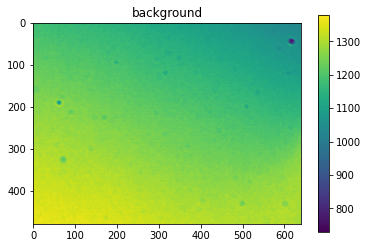

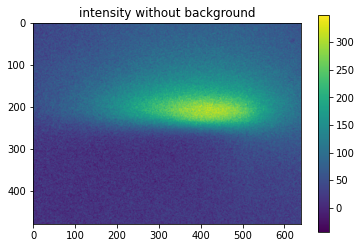

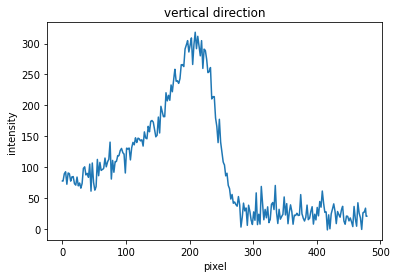

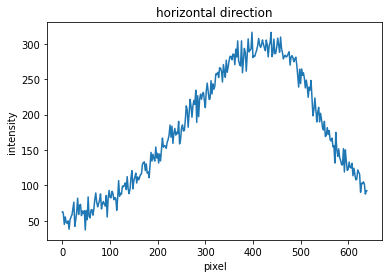

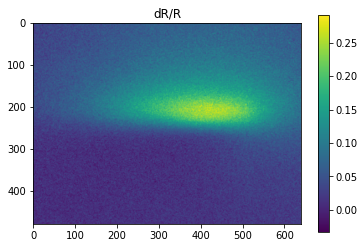

In [4]:
image = "/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023/30mm_per_sec/-12mm_35W_012.raw"
whole = get_blue(image)
# zoomin = get_bright(whole)
b_whole = back[6]
# fig 1: background
sc = plt.imshow(b_whole)
plt.colorbar(sc)
plt.title("background")
plt.show()
# fig 2: intensity without background
sc = plt.imshow(whole-b_whole)
plt.colorbar(sc)
plt.title("intensity without background")
plt.show()
# fig 3: vertical direction trend
plt.plot((whole-b_whole)[:,420])
plt.title("vertical direction")
plt.xlabel("pixel")
plt.ylabel("intensity")
plt.show()
# fig 4: horizontal direction trend
plt.plot((whole-b_whole)[210,:])
plt.title("horizontal direction")
plt.xlabel("pixel")
plt.ylabel("intensity")
plt.show()
# fig 5: dR/R intensity
sc = plt.imshow((whole - b_whole)/b_whole)
plt.colorbar(sc)
plt.title("dR/R")
plt.show()

### 3. input the fitting range here

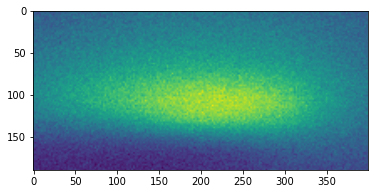

In [5]:
X_left_boundry = 100
X_right_boundry = 290
Y_left_boundry = 200
Y_right_boundry = 600
zoomin = get_bright(whole)
b_zoomin = get_bright(b_whole)
needed = zoomin - b_zoomin
plt.imshow(needed)

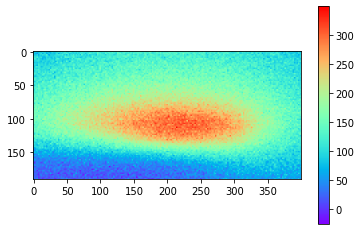

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Replace this with your actual data
data = needed

plt.imshow(data, cmap='rainbow', interpolation='nearest')
plt.colorbar()
plt.show()

# Plots:

In [7]:
v_list = [v for [v] in velocity_list]
Dict_1 = dict((k, fivemm_files[k][5:]) for k in v_list) # not included 0W files
dRoverR_1 = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_peak_dRoverR(file, back_intensity_list[i], gaus, gaus)
        con.append(val)
    dRoverR_1.append(con)

power_used = {} # not include 0W
for i in range(len(velocity_list)):
    [v] = velocity_list[i]
    power_used[v] = [int(j) for j in power_list[i][1:]]

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### 1. Plot dR/R vs frame for each velocity

In [ ]:
for i, (key, value) in enumerate(all_files.items()):
    power = [int(x) for x in power_list[i]][1:]
    files = all_files[key]
    
    for p in power:
        dR_list = []
        for file in tqdm(files):
            if "_{}W_".format(p) in str(file):
                print(str(file))
                dR = get_peak_dRoverR(file, back_intensity_list[i], gaus, gaus)
                dR_list.append(dR)
        
        x = [frame for frame in range(0,len(dR_list))] 
         
        plt.plot(x, dR_list, marker="o")
        plt.title("{}mm per sec".format(key))
        plt.xlabel("frame")
        plt.ylabel("dR/R")
        plt.ylim(0,0.4)
        
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_dRoverR_vs_frame/{}mmpersec.png".format(key), format="PNG")
    plt.close()

### 2. Temperature vs position for each velocity

In [ ]:
for i, (key, value) in enumerate(all_files.items()):
    power = [int(x) for x in power_list[i]][1:]
    files = all_files[key]
    
    for p in power:
        dR_list = []
        temp_list = []
        for file in tqdm(files):
            if "_{}W_".format(p) in str(file):
                print(str(file))
                dR = get_peak_dRoverR(file, back_intensity_list[i], gaus, gaus)
                dR_list.append(dR)
                temp_list.append(dR/0.00016+21)
                
        #convert the frame number to position 
        
        x = [frame for frame in range(0,len(dR_list))] 
        #position = [(frame-2.7)*int(key)/92.59 for frame in range(1,len(temp_list)+1)] why?
        position = [(frame/frame_rate-shutter_delay)*int(key) for frame in range(1,len(temp_list)+1)]
        
        plt.plot(position, temp_list, marker="o")

        #limit temperature to 1500C
        plt.ylim(0,1500)
        
        #limit position to 1-10mm
        plt.xlim(0,10)

        plt.xlabel("position (mm)")
        plt.ylabel("Temperature (Celsius)")
        plt.title("{}mm per sec".format(key))

    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_Temp_vs_position/{}mmpersec.png".format(key), format="PNG")
    plt.close()

### 3. dR/R vs power for each velocity

In [8]:
for i, v in enumerate(list(Si_melting_W.keys())):
    plt.plot(power_used[v], dRoverR_1[i], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.title("{}mm per sec".format(v))
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130/0130_dRoverR_vs_power/{}mm.png".format(v), format="PNG")
    plt.close()


### 4. Check kappa

0.00017732060413212932

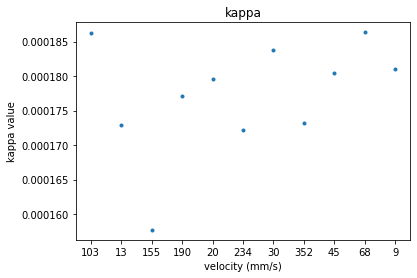

In [9]:
# gold and Si melt
import scipy.optimize
kappa_avg = []
for i, v in enumerate(list(Si_melting_W.keys())):
    popt, pcov = curve_fit(expo, power_used[v], dRoverR_1[i], p0 = [1, 0.00000001, 1], maxfev = 10000)
    #a, b, c = popt
    plt.plot(power_used[v], dRoverR_1[i], '.')
    y_pred = [expo(j, *popt) for j in power_used[v]]
    plt.plot(power_used[v], y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.title("{}mm per sec".format(v))
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130/0130_dRoverR_fit_figure/{}mm.png".format(v), format="PNG")
    plt.close()
    
    
    fun = lambda k: (expo(Si_melting_W[v], *popt) - (1410-21)*k)**2 + (expo(gold_melting_W[v], *popt) - (1064-21)*k)**2
    res = scipy.optimize.minimize(fun, 0.00016)
    temp_pred = [expo(j, *popt)/res.x for j in power_used[v]]
    plt.plot(power_used[v], temp_pred)
    
    plt.plot(Si_melting_W[v], 1410, marker="o",color = 'r', label='Si')
    plt.plot(gold_melting_W[v], 1064, marker="o", color = 'g', label='gold')
    plt.legend(loc="upper left")
    plt.xlabel("power")
    plt.ylabel("temperature")
    plt.title("{}mm per sec".format(v))
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130/0130_gold_Si_fit/{}mm.png".format(v), format="PNG")
    plt.close()
    
#     f = expo(Si_melting_W[v], *popt)
#     gold_m = 1410
#     dT = gold_m - 21
#     kappa = f / dT
    kappa_avg.append(float(res.x))

    
Dict_kappa_avg = dict(zip(list(Si_melting_W.keys()),kappa_avg))

plt.plot(list(Si_melting_W.keys()), kappa_avg, '.')
plt.xlabel("velocity (mm/s)")
plt.ylabel("kappa value")
plt.title("kappa")
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130/0130_kappa_gold&Si.png", format="PNG")

con = 0
for i, v in enumerate(Dict_kappa_avg.keys()):
    con = con + Dict_kappa_avg[v]
kappa_avg = con / len(Dict_kappa_avg)
kappa_avg

In [10]:
Dict_kappa_avg

{'103': 0.00018618042657282284,
 '13': 0.00017290111282756377,
 '155': 0.00015770469727234096,
 '190': 0.00017712794279672886,
 '20': 0.00017953041253198384,
 '234': 0.0001721801374518548,
 '30': 0.00018377394790821284,
 '352': 0.00017324408481112313,
 '45': 0.00018043806354722835,
 '68': 0.00018636254302267183,
 '9': 0.00018108327671089138}

### 5. Temperature vs power

In [10]:
peak_temp = []
for i, v in enumerate(list(Si_melting_W.keys())):
    tem = []
    for r in dRoverR_1[i]:
        t = get_peak_Temp(r, Dict_kappa_avg[v])
#         t = get_peak_Temp(r,avg_kappa)
#         t = get_peak_Temp(r,0.00016498400434141028)
#         t = get_peak_Temp(r, Dict_kappa_gold_avg[v])
#         t = get_peak_Temp(r, avg_kappa_2)
#         t = get_peak_Temp(r, Dict_kappa_avg[v])
        tem.append(t)
    peak_temp.append(tem)
    
Dict_peak_temp = dict(zip(list(Si_melting_W.keys()),peak_temp))

%matplotlib
for i,v in enumerate(Dict_peak_temp):
    plt.plot(power_used[v], Dict_peak_temp[v], label = "{}mm per sec".format(v))
    plt.title("Peak Temperature vs Power")
    plt.xlabel("power (W)")
    plt.ylabel("Temperature (Celsius)")
    plt.legend()
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130/0130_temp_vs_power.png", format="PNG")

Using matplotlib backend: <object object at 0x7fc25a463ec0>


### 6. 4mm frame, no background

In [ ]:
for I, v in enumerate(list(fivemm_files.keys())):
    for i, item in enumerate(fivemm_files[v]):
        original = get_blue(item)
        back = back_intensity_list[I]
        fig = original - back
        plt.imshow(fig)
        plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130/0130_4mm_frame_noback_figure/{}mm_4mmframe_{}.png".format(v,i), format="PNG")
        plt.close()

### input: decide which velocity to use to fit

In [12]:
# data used to fit Tpeak plane
v_fit_list = ['103','13', '155', '190','234','30','352','45', '68']

# Function 1. get_power(dwell, Tpeak) 

### f(power, log10 velocity) = Tpeak 

In [13]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

def function_Tpeak(data, a, b, c, d, e, f, g, h):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(v_fit_list):
    P = [int(p) for p in power_used[v]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = z_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters_Tpeak, covariance = curve_fit(function_Tpeak, [x_data, y_data], z_data,  maxfev=1000000)
print(parameters_Tpeak)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function_Tpeak(np.array([X, Y]), *parameters_Tpeak)

z_predicted = function_Tpeak([x_data, y_data], *parameters_Tpeak)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)
axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX
[ 1.35113524e+00 -3.46376984e-01 -6.25981538e+01  6.22807110e+00
  7.02953262e+02  2.16035934e+00  6.41942780e-02  2.24487522e-02]
455.93956769148593


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_5174/990343678.py:15: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


In [14]:
def get_peakT_from_fitting(dwell, power):
    v = 88200/dwell
    lnv = np.log(v)
    return function_Tpeak([power, lnv], *parameters_Tpeak)

def get_power(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    a, b, c, d, e, f, g, h= parameters_Tpeak
    eq1 = lambda x: (a+b*lnv+h*lnv**2)*x**(f+g*lnv) + (c+d*lnv)*x + e  - Tpeak
    sol = leastsq(eq1, 100)
    #return float(sol[0], sol[1]), float(sol[1])
    return float(sol[0])

In [15]:
get_power(150,1400)

60.337100346916266

# Function 2. Invertible function of get_power(dwell, Tpeak)

In [14]:
# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

def function(data, a, b, c, d, e):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y)*x**2.5 + (c+d*y) + e

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Si_melting_W.keys())):
    P = [int(p) for p in power_used[v]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = z_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=1000000)
print(parameters)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)
axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

[ 3.25350393e-01 -4.39176236e-02  3.89332148e+06  4.49445246e+01
 -3.89348354e+06]
2710.8498226128067


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_8840/690333852.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


# Function 3. get_lateral_profile(dwell, power, distance_from_center)

In [16]:
dRoverR_line = [] # Use v_fit_list. It only contains velocity in v_fit_list.
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    if v in v_fit_list:
        for file in Dict_1[v]:
            val = get_laterial_fit_line(file, back_intensity_list[i], two_lorentz)
            con.append(val)
        dRoverR_line.append(con)
    

temp_line = []    
for i, v in enumerate(v_fit_list):
    con_2 = []
    velo = dRoverR_line[i]
    for R in velo:
        temp = get_peak_Temp(R, Dict_kappa_avg[v])
        con_2.append(temp)
    temp_line.append(con_2)
    
parameters_all = []
for i, v in enumerate(v_fit_list):
    con_3 = []
    velo = temp_line[i]
    for t in velo:
        # [height, x_0, sigma1, sigma2] = fit(two_lorentz, t)
        par = fit(two_lorentz, t)
        con_3.append(par)
    parameters_all.append(con_3)

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### fit sigma1, sigma2 plane

In [17]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib


def function_sigma(data, a, b, c, d, e, f, g):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a*x**b)*(c*y**d)+e*x+f*y+g

points_1 = []
points_2 = []

for i, v in enumerate(v_fit_list):
    T = Dict_peak_temp[v]
    P = [int(p) for p in power_used[v]]
    # tau = [np.log(beamwidth / int(v))] * len(Dict_peak_temp[v])
    lnv = [np.log(int(v))] * len(Dict_peak_temp[v])
    sigma1 = [abs(el[2]) for el in parameters_all[i]]
    sigma2 = [abs(el[3]) for el in parameters_all[i]]
    # point1 = [list(x) for x in zip(*[P,tau,sigma1,T])]
    point1 = [list(x) for x in zip(*[P,lnv,sigma1,T])]
    points_1.append(point1)
    # point2 = [list(x) for x in zip(*[P,tau,sigma2,T])]
    point2 = [list(x) for x in zip(*[P,lnv,sigma2,T])]
    points_2.append(point2)

x_data = []
y_data = []
t_data = []
z_data_1 = []
z_data_2 = []

for velo in points_1:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # tau
        z_data_1.append(item[2]) # sigma1
        t_data.append(item[3]) # Tpeak
        
for velo in points_2:
    for item in velo:
        z_data_2.append(item[2]) # sigma2
               
x_data, y_data, z_data_1, z_data_2, t_data = np.array(x_data), np.array(y_data), np.array(z_data_1), np.array(z_data_2), np.array(t_data)

mask = t_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data_1 = z_data_1[mask]
z_data_2 = z_data_2[mask]

# mask_2 = z_data_1 < 1000
# x_data = x_data[mask_2]
# y_data = y_data[mask_2]
# z_data_1 = z_data_1[mask_2]
# z_data_2 = z_data_2[mask_2]

zscore_1 = np.abs(stats.zscore(z_data_1))
mask_2 = zscore_1 < 1
x_data = x_data[mask_2]
y_data = y_data[mask_2]
z_data_1 = z_data_1[mask_2]
z_data_2 = z_data_2[mask_2]

zscore_2 = np.abs(stats.zscore(z_data_2))
mask_3 = zscore_2 < 1
x_data = x_data[mask_3]
y_data = y_data[mask_3]
z_data_1 = z_data_1[mask_3]
z_data_2 = z_data_2[mask_3]

parameters_sigma1, covariance_1 = curve_fit(function_sigma, [x_data, y_data], z_data_1,  maxfev=1000000)
parameters_sigma2, covariance_2 = curve_fit(function_sigma, [x_data, y_data], z_data_2,  maxfev=1000000)

print(parameters_sigma1)
print(parameters_sigma2)

model_x_data = np.linspace(min(x_data), max(x_data), 100)
model_y_data = np.linspace(min(y_data), max(y_data), 100)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z1 = function_sigma(np.array([X, Y]), *parameters_sigma1)
Z2 = function_sigma(np.array([X, Y]), *parameters_sigma2)

z_predicted_1 = function_sigma([x_data, y_data], *parameters_sigma1)
z_predicted_2 = function_sigma([x_data, y_data], *parameters_sigma2)

differences_1 = np.subtract(z_data_1, z_predicted_1)
differences_2 = np.subtract(z_data_2, z_predicted_2)

squared_differences_1 = np.square(differences_1)
squared_differences_2 = np.square(differences_2)

mse_1 = squared_differences_1.mean()
mse_2 = squared_differences_2.mean()
print(mse_1)
print(mse_2)

Using matplotlib backend: MacOSX
[-8.71180101e-06  8.00174940e-01 -7.77408651e-05  3.65861278e-01
 -1.66817502e+00  2.41785174e+00  2.71940864e+02]
[-4.29313926e-04  8.14956902e-01 -4.54222731e-04  6.95773590e-01
 -4.02667195e+00  1.30642472e+01  2.58283831e+02]
121.5094954881383
101.42236080622443


In [18]:
f1 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes1 = Axes3D(f1)

axes1.plot_surface(X, Y, Z1, cmap=cm.hot, alpha=0.2)
axes1.scatter(x_data, y_data, z_data_1, s=500)

axes1.set_title('Scatter Plot')
axes1.set_xlabel('power - W', fontsize=30, labelpad=40)
axes1.set_ylabel('ln(v)',fontsize=30, labelpad=40)
axes1.set_zlabel('sigma1', fontsize=30, labelpad=40)

axes1.tick_params(axis='both', which='major', labelsize=30)
 
plt.show()
print(mse_1)

121.5094954881383


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_5174/4082552612.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes1 = Axes3D(f1)


In [19]:
f2 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes2 = Axes3D(f2)

axes2.plot_surface(X, Y, Z2, cmap=cm.hot, alpha=0.2)
axes2.scatter(x_data, y_data, z_data_2, s=500)

axes2.set_title('Scatter Plot')
axes2.set_xlabel('power - W', fontsize=30, labelpad=40)
axes2.set_ylabel('ln(v)',fontsize=30, labelpad=40)
axes2.set_zlabel('sigma2', fontsize=30, labelpad=40)

axes2.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse_2)

101.42236080622443


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_5174/266566414.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes2 = Axes3D(f2)


In [20]:
def get_sigma1(dwell, power):
    v = beamwidth/dwell
    lnv = np.log(v)
    [a,b,c,d,e,f,g] = [i for i in parameters_sigma1]
    return function_sigma([power, lnv], a,b,c,d,e,f,g)

def get_sigma2(dwell, power):
    v = beamwidth/dwell
    lnv = np.log(v)
    [a,b,c,d,e,f,g] = [i for i in parameters_sigma2]
    return function_sigma([power, lnv], a,b,c,d,e,f,g)

def get_lateral_profile(dwell, power, distance_from_center):
    v = beamwidth/dwell
    lnv = np.log(v)
    x = np.linspace(-250,249,500) #pixel
    y = two_lorentz(x, get_peakT_from_fitting(dwell, power), 0, get_sigma1(dwell, power), get_sigma2(dwell, power))
    plt.plot(x * pixel_size, y)
    plt.xlabel("position (mm)")
    plt.ylabel("Temperature (°C)")
    plt.title("{}us, {}W, {}mm from center".format(dwell, power, distance_from_center))
    pixel_number = distance_from_center/pixel_size
    if pixel_number <= 0:
        ans = lorentz(pixel_number, get_peakT_from_fitting(dwell, power), 0, get_sigma1(dwell, power))
    else:
        ans = lorentz(pixel_number, get_peakT_from_fitting(dwell, power), 0, get_sigma2(dwell, power))

    plt.plot(distance_from_center, ans, 'ro')
    plt.annotate("T = {} °C".format(round(ans)), xy=(distance_from_center, ans), xytext=(distance_from_center, ans))

    return ans  

def get_lateral_Tpeak(dwell, power, distance_from_center):
    v = beamwidth/dwell
    lnv = np.log(v)  
    pixel_number = distance_from_center/pixel_size
    if pixel_number <= 0:
        ans = lorentz(pixel_number, get_peakT_from_fitting(dwell, power), 0, get_sigma1(dwell, power))
    else:
        ans = lorentz(pixel_number, get_peakT_from_fitting(dwell, power), 0, get_sigma2(dwell, power))
    
    return ans  

# Function 4. Heat/Quench Rate Profile

## get_temp_time_prifile(dwell, power, distance_from_center)

In [21]:
dRoverR_all_points = [] # Use v_fit_list. It only contains velocity in v_fit_list.
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    if v in v_fit_list:
        for file in Dict_1[v]:
            val = get_dR_over_R(file, back_intensity_list[i])
            con.append(val)
        dRoverR_all_points.append(con)

temp_of_frame = []    
for i, v in enumerate(v_fit_list):
    con_2 = []
    velo = dRoverR_all_points[i]
    for R in velo:
        temp = get_peak_Temp(R, Dict_kappa_avg[v])
        con_2.append(temp)
    temp_of_frame.append(con_2)

temp_time_line = []
for i, v in enumerate(v_fit_list):
    con_3 = []
    velo = temp_of_frame[i]
    for temp in velo:
        temp_line = get_lines(temp)
        con_3.append(temp_line)
    temp_time_line.append(con_3)


In [22]:
parameters_all_quench = []
for i, v in enumerate(v_fit_list):
    con_4 = []
    velo = temp_time_line[i]
    for t in velo:
        con_5 = []
        for line in t:
            par = fit(two_lorentz, line)
        # [height, x_0, sigma1, sigma2] = fit(two_lorentz, t)
            con_5.append(par)
        con_4.append(con_5)
    parameters_all_quench.append(con_4)


### fit sigma1, sigma2 plane

In [23]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib


all_sigma1 = []
all_sigma2 = []

for i, v in enumerate(v_fit_list):
    con_sigma1 = []
    con_sigma2 = []
    for j in range(len(power_used[v])):
        sigma1 = [abs(el[2]) for el in parameters_all_quench[i][j]]
        sigma2 = [abs(el[3]) for el in parameters_all_quench[i][j]]
        con_sigma1.append(sigma1)
        con_sigma2.append(sigma2)
    all_sigma1.append(con_sigma1)
    all_sigma2.append(con_sigma2)

n = Y_right_boundry - Y_left_boundry
points_1 = [] # store the points for sigma1
points_2 = [] # store the points for sigma2

for i, v in enumerate(v_fit_list):
    T = Dict_peak_temp[v]
    P = [int(p) for p in power_used[v]]
    lnv = [np.log(int(v))] * len(Dict_peak_temp[v])
    distance_from_center = generate_consecutive_integers(0, Y_right_boundry-Y_left_boundry)
    # a list [-75...0...74]
    
    for j in range(len(power_used[v])):
             
        for l in range(n):
            
            point1 = [list(x) for x in zip(*[[P[j] for i in range(n)], [lnv[j] for i in range(n)], all_sigma1[i][j], distance_from_center, [T[j] for i in range(n)]])]
            points_1.append(point1)
            point2 = [list(x) for x in zip(*[[P[j] for i in range(n)], [lnv[j] for i in range(n)], all_sigma2[i][j], distance_from_center, [T[j] for i in range(n)]])]
            points_2.append(point2)

x_data = []
y_data = []
d_data = []
t_data = []
z_data_1 = []
z_data_2 = []

for velo in points_1:  
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # lnv
        d_data.append(item[3]) # distance from center
        z_data_1.append(item[2]) # sigma1
        t_data.append(item[4]) # Tpeak
        
for velo in points_2:
    for item in velo:
        z_data_2.append(item[2]) # sigma2
               
x_data, y_data, z_data_1, z_data_2, t_data, d_data = np.array(x_data), np.array(y_data), np.array(z_data_1), np.array(z_data_2), np.array(t_data), np.array(d_data)

mask = t_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
d_data = d_data[mask]
z_data_1 = z_data_1[mask]
z_data_2 = z_data_2[mask]

# mask_2 = z_data_1 < 100000
# x_data = x_data[mask_2]
# y_data = y_data[mask_2]
# d_data = d_data[mask_2]
# z_data_1 = z_data_1[mask_2]
# z_data_2 = z_data_2[mask_2]

zscore_1 = np.abs(stats.zscore(z_data_1))
mask_2 = zscore_1 < 1
x_data = x_data[mask_2]
y_data = y_data[mask_2]
d_data = d_data[mask_2]
z_data_1 = z_data_1[mask_2]
z_data_2 = z_data_2[mask_2]

zscore_2 = np.abs(stats.zscore(z_data_2))
mask_3 = zscore_2 < 1
x_data = x_data[mask_3]
y_data = y_data[mask_3]
d_data = d_data[mask_3]
z_data_1 = z_data_1[mask_3]
z_data_2 = z_data_2[mask_3]

data = {'power': list(x_data),
        'lnv': list(y_data),
        'distance_from_center': list(d_data),
        'sigma1': list(z_data_1),
        'sigma2': list(z_data_2)     
        }

df = pd.DataFrame(data)

x = df[['power','lnv','distance_from_center']]
y1 = df['sigma1']
y2 = df['sigma2']

Using matplotlib backend: MacOSX


In [24]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
regr = linear_model.LinearRegression()
regr.fit(x, y1)

print('Intercept 1: \n', regr.intercept_)
print('Coefficients 1: \n', regr.coef_)

# # with statsmodels
# x = sm.add_constant(x) # adding a constant
 
# model = sm.OLS(y1, x).fit()
# predictions = model.predict(x)  
 
# print_model = model.summary()
# print(print_model)
# print(model.ssr/len(x)) # mean squared error

z_predicted_1 = regr.predict(x)
differences_1 = np.subtract(z_data_1, z_predicted_1)
squared_differences_1 = np.square(differences_1)
mse_1 = squared_differences_1.mean()
print(mse_1)

Intercept 1: 
 293.32393286237317
Coefficients 1: 
 [ -1.81163682 -24.85681932   0.16243418]
1941790.0030614212


In [25]:
def get_sigma1_quench(dwell, power, distance_from_center):
    v = 88200/dwell
    lnv = np.log(v)
    pixel_number = distance_from_center/pixel_size
    data = {'power': [power],
        'lnv': [lnv],
        'distance_from_center': [pixel_number]
        #'sigma1': list(z_data_1),
        #'sigma2': list(z_data_2)     
        }
    df = pd.DataFrame(data)

    a = df[['power','lnv','distance_from_center']]

    return regr.predict(a)

In [26]:
regr_2 = linear_model.LinearRegression()
regr_2.fit(x, y2)
print('Intercept 2: \n', regr_2.intercept_)
print('Coefficients 2: \n', regr_2.coef_)

z_predicted_2 = regr.predict(x)
differences_2 = np.subtract(z_data_2, z_predicted_2)
squared_differences_2 = np.square(differences_2)
mse_2 = squared_differences_2.mean()
print(mse_2)


Intercept 2: 
 49.725571972145325
Coefficients 2: 
 [-0.90516379  5.0246616   0.09593624]
6768.763348631548


In [27]:
def get_sigma2_quench(dwell, power, distance_from_center):
    v = 88200/dwell
    lnv = np.log(v)
    pixel_number = distance_from_center/pixel_size
    data = {'power': [power],
        'lnv': [lnv],
        'distance_from_center': [pixel_number]    
        }
    df = pd.DataFrame(data)

    a = df[['power','lnv','distance_from_center']]

    return regr_2.predict(a)

In [28]:
from numpy import diff

def get_quench_profile(dwell, power, distance_from_center):
    v = beamwidth/dwell
    lnv = np.log(v)
    x = np.linspace(-250,249,500) #pixel
    y = two_lorentz(x, get_lateral_Tpeak(dwell, power, distance_from_center), 0, get_sigma1_quench(dwell, power, distance_from_center), get_sigma2_quench(dwell, power, distance_from_center))
    plt.plot(x * pixel_size, y)
    plt.xlabel("position")
    plt.ylabel("Temperature (Celsius)")
    plt.title("{}us, {}W, {}from center".format(dwell, power, distance_from_center))
    pixel_number = distance_from_center/pixel_size
    

def get_quench_data(dwell, power, distance_from_center):
    v = beamwidth/dwell
    lnv = np.log(v)
    #pixel_number = distance_from_center/pixel_size
    x = np.linspace(-250,249,500) #pixel
    y = two_lorentz(x, get_lateral_Tpeak(dwell, power, distance_from_center), 0, get_sigma1_quench(dwell, power, distance_from_center), get_sigma2_quench(dwell, power, distance_from_center))
        
    return y

def pixel_to_position(pixel):
    return pixel * pixel_size

def get_rate(dwell, power, distance_from_center):
    v = beamwidth/dwell
    lnv = np.log(v)
    #pixel_number = distance_from_center/pixel_size
    # x = np.linspace(-250,249,500) #pixel #改掉的
    x = np.linspace(-1200,1200,500) #新加的
    y = get_quench_data(dwell, power, distance_from_center)
    #新加的
    y = y[::-1]
    #新加的
    positions = pixel_to_position(x) 
    times = positions/v
    der = np.diff(y)/np.diff(times)
    plt.plot(times[:-1], der, 'r')
    plt.xlabel("time (s)")
    plt.ylabel("Temperature change rate(°C/s)")
    plt.title("heat/quench rate: {}us, {}W, {}from center".format(dwell, power, distance_from_center))
    # plt.plot(times, y, 'g')
    #plt.show()


    return np.max(der), np.min(der)
    # return times

def get_quench_profile_time(dwell, power, distance_from_center):
    v = beamwidth/dwell
    lnv = np.log(v)
    # x = np.linspace(-250,249,500) #pixel
    x = np.linspace(-1250,1249,500)
    positions = pixel_to_position(x) 
    times = positions/v
    #新加的
    times = positions/v*100
    #新加的
    y = two_lorentz(x, get_lateral_Tpeak(dwell, power, distance_from_center), 0, get_sigma1_quench(dwell, power, distance_from_center), get_sigma2_quench(dwell, power, distance_from_center))
    # 新加的
    y = y[::-1]
    # 新加的
    plt.plot(times, y)
    plt.xlabel("time (ms)") #改的
    plt.ylabel("Temperature (°C)")
    plt.title("{}us, {}W, {}from center".format(dwell, power, distance_from_center))
    #plt.show()


# Here, Here, Here!

In [29]:
from ipywidgets import interact, Dropdown, FloatText, Button, Output


# Define the function that will be called when the user clicks the Enter button
def on_button_click(b):
    with output:
        output.clear_output()
        if dropdown.value == 'get power':
            result = get_power(input_dwell.value, input_Tpeak.value)
            print(result,'W')
        elif dropdown.value == 'lateral profile':
            result = get_lateral_profile(input_dwell.value, input_power.value, input_d_from_center.value)
            print(result, '°C')
            #plt.gcf()
        elif dropdown.value == 'quench profile':
            result = get_quench_profile_time(input_dwell.value, input_power.value, input_d_from_center.value)
            
            #plt.gcf()
        elif dropdown.value == 'heat/quench rate':
            result = get_rate(input_dwell.value, input_power.value, input_d_from_center.value)
            print(result,'°C/s')
            #plt.gcf()

# Define the dropdown menu and input boxes
dropdown = Dropdown(options=['get power',  'lateral profile', 'quench profile', 'heat/quench rate'], value=None)
input_dwell = FloatText(value=None, description='dwell time(us):', style={'description_width': '150px'})
input_Tpeak = FloatText(value=None, description='peak temperature(°C):', style={'description_width': '150px'})
input_power = FloatText(value=None, description='power(W):',style={'description_width': '150px'})
input_d_from_center = FloatText(value=None, description='distance from center(mm):', style={'description_width': '150px'})
button = Button(description='Enter')
output = Output()

# Use the interact function to display the dropdown and input boxes, and the button to call the on_button_click function
display(dropdown)
display(input_dwell)
display(input_Tpeak)
display(input_power)
display(input_d_from_center)
display(button)
display(output)
button.on_click(on_button_click)




Dropdown(options=('get power', 'lateral profile', 'quench profile', 'heat/quench rate'), value=None)

FloatText(value=0.0, description='dwell time(us):', style=DescriptionStyle(description_width='150px'))

FloatText(value=0.0, description='peak temperature(°C):', style=DescriptionStyle(description_width='150px'))

FloatText(value=0.0, description='power(W):', style=DescriptionStyle(description_width='150px'))

FloatText(value=0.0, description='distance from center(mm):', style=DescriptionStyle(description_width='150px'…

Button(description='Enter', style=ButtonStyle())

Output()